Import libraries

In [39]:
# Import required libraries

import pandas as pd
import os
import requests
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.ticker as mticker

%matplotlib inline


In [3]:
# Load the environment variables from the .env file

load_dotenv()


True

Tickers list

In [4]:
#Create list of tickers for the bond portfolio

tickers = ["BLV", "BND", "EDV", "VCLT", "VGLT"]


#Review bond portfolio tickers

tickers


['BLV', 'BND', 'EDV', 'VCLT', 'VGLT']

API key

In [5]:
# Set the variables for the Alpaca API and secret keys

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca tradeapi.REST object

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    

Alpaca API call

In [6]:
# Set timeframe to 1D 

timeframe = "1D"


# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day

start_date = pd.Timestamp("2018-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-11-05", tz="America/New_York").isoformat()


In [7]:
# Use the Alpaca get_barset function to get current closing prices the bond portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame


bonds_prices = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df


# Review the bond tickers Alpaca DataFrame

bonds_prices.head()


BLV                                       BND  \
                            open     high      low  close    volume   open   
time                                                                         
2018-01-02 00:00:00-05:00  94.88  94.8890  93.8266  94.11  351261.0  81.45   
2018-01-03 00:00:00-05:00  94.44  94.5936  94.1450  94.52  130105.0  81.43   
2018-01-04 00:00:00-05:00  94.38  94.7000  94.1665  94.62  105525.0  81.33   
2018-01-05 00:00:00-05:00  94.55  94.6420  94.1400  94.37  100914.0  81.35   
2018-01-08 00:00:00-05:00  94.60  94.6300  94.1022  94.38  112540.0  81.33   

                                                           ...   VCLT  \
                            high    low  close     volume  ...   open   
time                                                       ...          
2018-01-02 00:00:00-05:00  81.50  81.22  81.32  2891040.0  ...  95.58   
2018-01-03 00:00:00-05:00  81.43  81.29  81.40  2044200.0  ...  95.07   
2018-01-04 00:00:00-05:00  81.37  81.25  81.35  1914914.0  ...  95.12   
2018-01-05 00:00:00-05:00  81.36  81.20  81.24  2547559.0  ...  95.25   
2018-01-08 00:00:00-05:00  81.33  81.21  81.26  2072870.0  ...  95.40   

                                                              VGLT          \
                              high      low   close  volume   open    high   
time                                                                         
2018-01-02 00:00:00-05:00  95.6000  94.5500  94.845  675183  77.81  77.840   
2018-01-03 00:00:00-05:00  95.4000  94.8400  95.245  189260  77.47  77.579   
2018-01-04 00:00:00-05:00  95.4100  94.9292  95.370  169777  77.23  77.550   
2018-01-05 00:00:00-05:00  95.4348  95.0000  95.150  239950  77.39  77.590   
2018-01-08 00:00:00-05:00  95.4000  94.9500  95.150  148223  77.45  77.500   

                                                     
                               low  close    volume  
time                                                 
2018-01-02 00:00:00-05:00  76.9510  77.22  115044.0  
2018-01-03 00:00:00-05:00  77.1699  77.51   31158.0  
2018-01-04 00:00:00-05:00  77.0900  77.53   71279.0  
2018-01-05 00:00:00-05:00  77.1100  77.28   72122.0  
2018-01-08 00:00:00-05:00  77.0158  77.21   94759.0  

[5 rows x 25 columns]

Monte Carlo 10 year simulation

In [8]:
# Configure the Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split evenly across bonds.
# Run 1000 samples.

MC_bonds_10 = MCSimulation(
    portfolio_data = bonds_prices,
    weights = [.2, .2, .2, .2, .2],
    num_simulation = 1000,
    num_trading_days = 252*10)


# Review the simulation input data

MC_bonds_10.portfolio_data.head()


BLV                                     \
                            open     high      low  close    volume   
time                                                                  
2018-01-02 00:00:00-05:00  94.88  94.8890  93.8266  94.11  351261.0   
2018-01-03 00:00:00-05:00  94.44  94.5936  94.1450  94.52  130105.0   
2018-01-04 00:00:00-05:00  94.38  94.7000  94.1665  94.62  105525.0   
2018-01-05 00:00:00-05:00  94.55  94.6420  94.1400  94.37  100914.0   
2018-01-08 00:00:00-05:00  94.60  94.6300  94.1022  94.38  112540.0   

                                          BND                       ...  \
                          daily_return   open   high    low  close  ...   
time                                                                ...   
2018-01-02 00:00:00-05:00          NaN  81.45  81.50  81.22  81.32  ...   
2018-01-03 00:00:00-05:00     0.004357  81.43  81.43  81.29  81.40  ...   
2018-01-04 00:00:00-05:00     0.001058  81.33  81.37  81.25  81.35  ...   
2018-01-05 00:00:00-05:00    -0.002642  81.35  81.36  81.20  81.24  ...   
2018-01-08 00:00:00-05:00     0.000106  81.33  81.33  81.21  81.26  ...   

                              VCLT                                VGLT  \
                               low   close  volume daily_return   open   
time                                                                     
2018-01-02 00:00:00-05:00  94.5500  94.845  675183          NaN  77.81   
2018-01-03 00:00:00-05:00  94.8400  95.245  189260     0.004217  77.47   
2018-01-04 00:00:00-05:00  94.9292  95.370  169777     0.001312  77.23   
2018-01-05 00:00:00-05:00  95.0000  95.150  239950    -0.002307  77.39   
2018-01-08 00:00:00-05:00  94.9500  95.150  148223     0.000000  77.45   

                                                                          
                             high      low  close    volume daily_return  
time                                                                      
2018-01-02 00:00:00-05:00  77.840  76.9510  77.22  115044.0          NaN  
2018-01-03 00:00:00-05:00  77.579  77.1699  77.51   31158.0     0.003756  
2018-01-04 00:00:00-05:00  77.550  77.0900  77.53   71279.0     0.000258  
2018-01-05 00:00:00-05:00  77.590  77.1100  77.28   72122.0    -0.003225  
2018-01-08 00:00:00-05:00  77.500  77.0158  77.21   94759.0    -0.000906  

[5 rows x 30 columns]

In [9]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns

MC_bonds_10.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999367,1.002895,1.000584,0.996772,1.001010,0.997670,0.994538,0.992088,0.999425,0.998268,...,0.995134,1.001428,0.993545,0.997699,1.008768,1.000699,1.002817,1.000775,0.998758,1.002950
2,1.002243,1.006558,0.996720,0.999535,1.005791,1.004478,0.992576,0.993234,1.005085,0.997520,...,0.996454,1.006444,0.990782,0.995735,1.008961,0.996891,1.005655,1.002997,0.995100,1.000774
3,0.998002,1.011333,0.995826,1.004632,1.008168,1.003745,0.990023,0.986571,1.007407,0.998690,...,1.000784,1.006665,0.995855,0.989356,1.010113,0.993867,1.012590,1.000296,0.998147,0.994747
4,1.000332,1.012216,0.990879,1.002432,0.997969,1.007616,0.992307,0.987533,1.003906,0.995790,...,0.995383,1.010523,1.000351,0.985047,1.009486,0.992325,1.004949,0.997711,0.997594,0.999575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.330639,1.420016,1.799778,2.034110,1.437887,1.564915,1.179339,1.217524,1.367821,1.835766,...,1.405353,1.461624,1.032228,1.948619,1.386266,1.717111,1.874559,1.233916,1.293266,1.820326
2517,1.336547,1.412692,1.806922,2.034447,1.437914,1.570218,1.180588,1.221830,1.366852,1.832348,...,1.402768,1.460851,1.035594,1.952235,1.394030,1.714601,1.876950,1.234666,1.297306,1.822051
2518,1.333977,1.409949,1.819367,2.028422,1.437437,1.566173,1.178609,1.221968,1.373452,1.846576,...,1.400663,1.463862,1.038017,1.966938,1.403786,1.710790,1.867168,1.240746,1.292614,1.814971
2519,1.340114,1.407238,1.818962,2.021986,1.429311,1.565210,1.181347,1.225063,1.366525,1.841620,...,1.405066,1.470287,1.035308,1.977264,1.404285,1.704557,1.871987,1.241877,1.301775,1.825013


Monte Carlo 10 year visualizations & stats

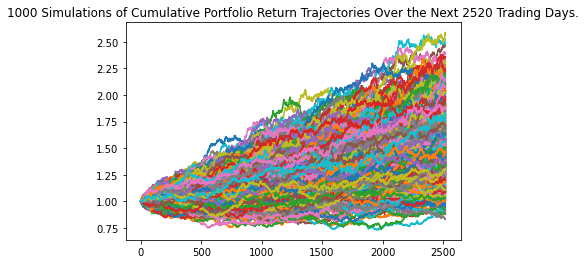

In [10]:
# Plot the 10 year MC simulation for bonds

MC_bonds_10_line_plot = MC_bonds_10.plot_simulation()


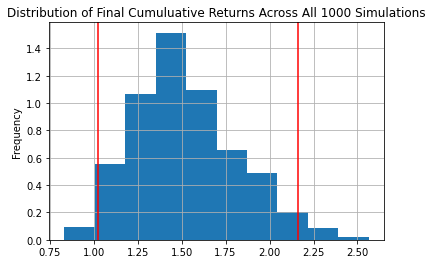

In [37]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram

plot = MC_bonds_10_bar_plot = MC_bonds_10.plot_distribution()
plot.grid()


In [12]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable

MC_bonds_10_table = MC_bonds_10.summarize_cumulative_return()


# Review the 10-year Monte Carlo summary statistics

print(MC_bonds_10_table)


count           1000.000000
mean               1.522257
std                0.295071
min                0.833469
25%                1.320342
50%                1.490845
75%                1.698888
max                2.563671
95% CI Lower       1.026038
95% CI Upper       2.161584
Name: 2520, dtype: float64


Monte Carlo 10 year 95% confidence interval

In [13]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the bond portfolio

ci_lower_10_cumulative_return = round(MC_bonds_10_table[8] * 10000,2)
ci_upper_10_cumulative_return = round(MC_bonds_10_table[9] * 10000,2)


# Print the result of your calculations

print(f"There is a 95% chance that the bond portfolio will end up within the range of ${ci_lower_10_cumulative_return} and ${ci_upper_10_cumulative_return} in 10 years.")


There is a 95% chance that the bond portfolio will end up within the range of $10260.38 and $21615.84 in 10 years.


Monte Carlo 30 year simulation

In [14]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split evenly across bonds.
# Run 1000 samples.

MC_bonds_30 = MCSimulation(
    portfolio_data = bonds_prices,
    weights = [.2, .2, .2, .2, .2],
    num_simulation = 1000,
    num_trading_days = 252*30)


# Review the simulation input data

MC_bonds_30.portfolio_data.head()


BLV                                     \
                            open     high      low  close    volume   
time                                                                  
2018-01-02 00:00:00-05:00  94.88  94.8890  93.8266  94.11  351261.0   
2018-01-03 00:00:00-05:00  94.44  94.5936  94.1450  94.52  130105.0   
2018-01-04 00:00:00-05:00  94.38  94.7000  94.1665  94.62  105525.0   
2018-01-05 00:00:00-05:00  94.55  94.6420  94.1400  94.37  100914.0   
2018-01-08 00:00:00-05:00  94.60  94.6300  94.1022  94.38  112540.0   

                                          BND                       ...  \
                          daily_return   open   high    low  close  ...   
time                                                                ...   
2018-01-02 00:00:00-05:00          NaN  81.45  81.50  81.22  81.32  ...   
2018-01-03 00:00:00-05:00     0.004357  81.43  81.43  81.29  81.40  ...   
2018-01-04 00:00:00-05:00     0.001058  81.33  81.37  81.25  81.35  ...   
2018-01-05 00:00:00-05:00    -0.002642  81.35  81.36  81.20  81.24  ...   
2018-01-08 00:00:00-05:00     0.000106  81.33  81.33  81.21  81.26  ...   

                              VCLT                                VGLT  \
                               low   close  volume daily_return   open   
time                                                                     
2018-01-02 00:00:00-05:00  94.5500  94.845  675183          NaN  77.81   
2018-01-03 00:00:00-05:00  94.8400  95.245  189260     0.004217  77.47   
2018-01-04 00:00:00-05:00  94.9292  95.370  169777     0.001312  77.23   
2018-01-05 00:00:00-05:00  95.0000  95.150  239950    -0.002307  77.39   
2018-01-08 00:00:00-05:00  94.9500  95.150  148223     0.000000  77.45   

                                                                          
                             high      low  close    volume daily_return  
time                                                                      
2018-01-02 00:00:00-05:00  77.840  76.9510  77.22  115044.0          NaN  
2018-01-03 00:00:00-05:00  77.579  77.1699  77.51   31158.0     0.003756  
2018-01-04 00:00:00-05:00  77.550  77.0900  77.53   71279.0     0.000258  
2018-01-05 00:00:00-05:00  77.590  77.1100  77.28   72122.0    -0.003225  
2018-01-08 00:00:00-05:00  77.500  77.0158  77.21   94759.0    -0.000906  

[5 rows x 30 columns]

In [15]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns

MC_bonds_30.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000260,1.002339,0.991256,1.004881,0.997286,0.995893,0.995920,0.998640,1.002103,1.002794,...,0.997631,1.000964,1.000396,1.001534,1.001742,0.999783,0.996835,1.008679,1.002419,0.999990
2,1.007630,1.003111,0.978569,1.004484,0.995576,0.996647,0.992671,0.994087,1.006124,1.008163,...,1.001467,1.001326,0.998600,0.997877,1.000379,0.996289,0.991012,1.006999,1.002057,0.998450
3,1.006532,1.004386,0.985334,1.002217,0.986461,0.992571,0.992524,0.992409,1.001349,1.005020,...,1.004070,1.007200,0.995308,0.995185,0.995134,1.004628,0.987239,1.004822,0.998873,0.998333
4,1.007636,1.001546,0.980355,1.002133,0.989629,0.989431,0.988941,0.989947,1.001181,1.003474,...,1.010848,1.011874,0.998304,0.993378,0.990198,1.007894,0.991747,1.008153,0.994116,0.997142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,4.217370,4.889154,4.746858,3.019967,3.883969,2.876320,3.911284,4.052873,3.252016,4.787404,...,2.414075,3.652028,2.874660,3.138363,3.685711,4.456168,4.822213,5.994165,4.351764,1.896826
7557,4.224608,4.876363,4.735903,3.028405,3.878473,2.887351,3.918245,4.041892,3.240568,4.791712,...,2.412617,3.644917,2.877175,3.147624,3.671138,4.465375,4.816506,5.993720,4.340136,1.909792
7558,4.221417,4.891058,4.729060,3.034804,3.864235,2.882035,3.922967,4.030435,3.247969,4.773310,...,2.420314,3.648330,2.875042,3.131440,3.680658,4.477274,4.831588,5.974362,4.334620,1.910287
7559,4.248428,4.912534,4.718624,3.021213,3.897947,2.879294,3.936302,4.002434,3.252048,4.789611,...,2.410338,3.647973,2.862174,3.133100,3.663336,4.482300,4.841705,5.978943,4.334989,1.895949


Monte Carlo 30 year visualizations & stats

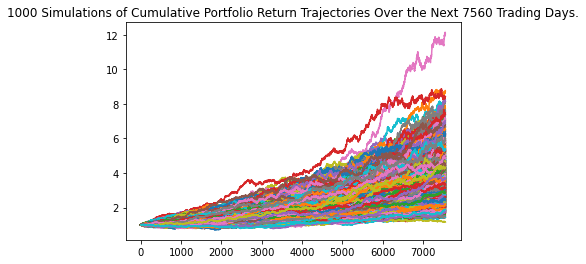

In [16]:
# Plot the 30 year MC simulation for bonds

MC_bonds_30_line_plot = MC_bonds_30.plot_simulation()

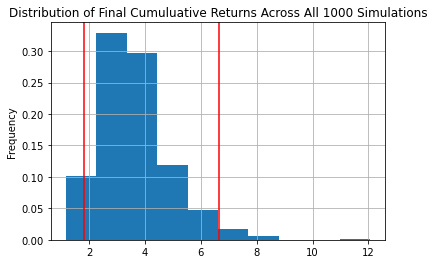

In [38]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram

plot = MC_bonds_30_bar_plot = MC_bonds_30.plot_distribution()
plot.grid()


In [18]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable

MC_bonds_30_table = MC_bonds_30.summarize_cumulative_return()


# Review the 10-year Monte Carlo summary statistics

print(MC_bonds_30_table)

count           1000.000000
mean               3.613882
std                1.243910
min                1.158978
25%                2.738397
50%                3.431455
75%                4.219218
max               12.064352
95% CI Lower       1.808103
95% CI Upper       6.638071
Name: 7560, dtype: float64


Monte Carlo 30 year 95% confidence interval

In [19]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the bond portfolio

ci_lower_30_cumulative_return = round(MC_bonds_30_table[8] * 10000,2)
ci_upper_30_cumulative_return = round(MC_bonds_30_table[9] * 10000,2)


# Print the result of your calculations

print(f"There is a 95% chance that the bond portfolio will end up within the range of ${ci_lower_30_cumulative_return} and ${ci_upper_30_cumulative_return} in 30 years.")

There is a 95% chance that the bond portfolio will end up within the range of $18081.03 and $66380.71 in thirty years.


Closing price dataframe

In [20]:

# Create an empty DataFrame to populate the closing prices on the bonds

bonds_closing_prices = pd.DataFrame()


# Use for-loop to pull the tickers' closing prices and populate the bonds_closing_prices DataFrame

for ticker in tickers:
    bonds_closing_prices[ticker] = bonds_prices[ticker]["close"] 


# Review DataFrame

bonds_closing_prices


,BLV,BND,EDV,VCLT,VGLT
time,,,,,
2018-01-02 00:00:00-05:00,94.110,81.320,117.50,94.845,77.220
2018-01-03 00:00:00-05:00,94.520,81.400,119.69,95.245,77.510
2018-01-04 00:00:00-05:00,94.620,81.350,119.94,95.370,77.530
2018-01-05 00:00:00-05:00,94.370,81.240,119.42,95.150,77.280
2018-01-08 00:00:00-05:00,94.380,81.260,119.30,95.150,77.210
...,...,...,...,...,...
2021-11-01 00:00:00-04:00,103.265,85.150,138.15,106.610,88.540
2021-11-02 00:00:00-04:00,103.620,85.335,139.05,107.100,88.930
2021-11-03 00:00:00-04:00,102.960,85.160,137.16,106.720,88.140


Calculate aggregate daily and annual returns

In [21]:
# Calculate the bonds portfolio aggregate daily returns

bonds_portfolio_returns = bonds_closing_prices.sum(axis=1).pct_change().dropna()


# Review the first 5 rows of the aggregate daily returns

bonds_portfolio_returns.head()


time
2018-01-03 00:00:00-05:00    0.007247
2018-01-04 00:00:00-05:00    0.000950
2018-01-05 00:00:00-05:00   -0.002880
2018-01-08 00:00:00-05:00   -0.000342
2018-01-09 00:00:00-05:00   -0.014776
dtype: float64

In [22]:
# Calculate the annual average return data for the for bond portfolios
# Use 252 as the number of trading days in the year

bonds_portfolio_avg_returns = bonds_portfolio_returns.mean() * 252


# Review the annual average returns for the bond portfolio

bonds_portfolio_avg_returns


0.21230840423099864

Calculate standard deviation and annual standard deviation

In [23]:
# Calculate the bonds portfolio standard deviation

bonds_portfolio_std = bonds_portfolio_returns.std()


# Review the standard devations

bonds_portfolio_std


0.04005170186051279

In [24]:
# Calculate the annualized standard deviation (252 trading days) of the bond portfolio

bonds_portfolio_std_annualized = (bonds_portfolio_std * np.sqrt(252))


# Review the annualized std for the bond portfolio

bonds_portfolio_std_annualized


0.6358010562469188

Calculation Sharpe ratio

In [25]:
# Calculate the annualized Sharpe Ratios for the bond portfolio

bonds_portfolio_sharpe_ratio = bonds_portfolio_avg_returns / bonds_portfolio_std_annualized


# Review the Sharpe Ratio for the bonds

bonds_portfolio_sharpe_ratio


0.33392269821669945

Calculate & plot cumulative returns 

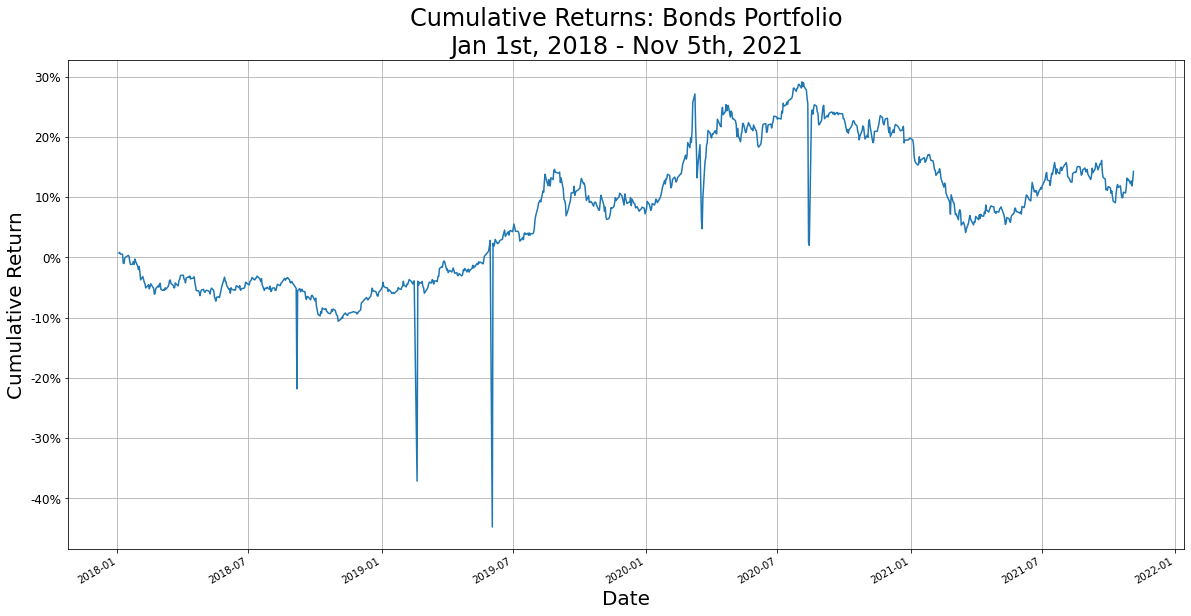

In [42]:
# Calculate the bond portoflio cumulative returns

bonds_cum_return = (1 + bonds_portfolio_returns).cumprod() -1

plot = bonds_cum_return.plot(
    title='Cumulative Returns: Bonds Portfolio\n'
                'Jan 1st, 2018 - Nov 5th, 2021',
                figsize=(20,10))

# format title
title =  plot.get_title()
plot.set_title(title, fontdict={'fontsize':24})

# format axes
plot.set_xlabel('Date', fontdict={'fontsize':20})
plot.set_ylabel('Cumulative Return', fontdict={'fontsize':20})
yticks_loc = plot.get_yticks().tolist()
plot.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
plot.set_yticklabels(['{:,.0%}'.format(x) for x in yticks_loc],fontdict={'fontsize':12})

plot.grid()


Write cum returns df to csv

In [45]:
# Write the bonds cumulative returns dataframe to a csv for consolidation

bonds_cum_return.to_csv('../data/cum_returns_bonds.csv')
